# Deep Q-Learning Cartpole

Using what I learned in Lazy Programmer's Udemy class Deep Reinforcement Learning in Python, I'm going to try and create my own DQN that can solve OpenAI's Cartpole problem.


For dqn, I didn't update Q every action step as should be done when using TD(0). I also didn't update each new state action pair with a set batch. Doing both these things was quite slow in combination (especially fitting on every action step).

What I decided to do was treat the Q network more like a neural network. I collected all state action pairs for an entire episode and add these with a large batch (128) of previous pairs (experience replay). Then I fit this entire group for 10 epochs (normally only 1 epoch is used as Q is updated every action step). I found that this greatly increased my run time and greatly increased the stability and consistency of the network. Before it seemed hit or miss off the start whether the agent would converge on a solution. Now it seems to do it reliably (although keeping it at the top once it's reached it is another story).

In [1]:
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop
import random
from collections import deque

Using TensorFlow backend.


In [2]:
# Create DQN class.
class Agent:
    def __init__(self, state_num, action_num):
        self.action_num = action_num
        self.gamma = 0.95 # Discount rate.
        self.batch = 128 # Number of replayed experiences batched together.
        self.experiences = deque(maxlen = 3000)
        self.episode_experiences = deque()
        
        # Create Neural Network that will act as a function
        # approximator for Q[s,a].
        self.model = Sequential()
        # First dense layer with relu activation.
        self.model.add(Dense(24, input_dim=state_num))
        self.model.add(Activation('relu'))
        # Second dense layer with relu activation.
        self.model.add(Dense(24))
        self.model.add(Activation('relu'))
        # Output layer with linear activation.
        self.model.add(Dense(self.action_num))
        self.model.add(Activation('linear'))
        # Loss function.
        self.model.compile(loss = 'mse', optimizer=Adam(lr = 0.001))#,
              #metrics=['categorical_accuracy'])
        
        self.model.summary()
        
    def ExploitAction(self, state):
        action_values = self.model.predict(state)
        exploit_action_index = np.argmax(action_values[0])
        return exploit_action_index
        
    def ExploreAction(self):
        return np.random.choice(self.action_num,1)[0]
    
    def AddEpisodeExperience(self, s, a, r, s2, episode_over):
        self.episode_experiences.append((s, a, r, s2, episode_over))
    
    def UpdateQ(self):
        if (len(self.experiences) <= self.batch-1):
            self.experiences.extend(self.episode_experiences)
            return
        # Update not only current state but randomly
        # selected experiences to replay.
        experience_replay = random.sample(self.experiences, self.batch-1)
        
        # Add all episode experiences to experiences and replay.
        experience_replay.extend(self.episode_experiences)
        self.experiences.extend(self.episode_experiences)
        self.episode_experiences = deque()
        
        # Try treating Q more as a deep neural network and less
        # like updating a function approximator by doing all inputs at once
        # and for multiple epochs.
        # THIS GREATLY INCREASED STABILITY OF AGENT AND CONSISTENCY
        # OF CONVERGING TO GOOD SOLUTION.
        all_s_t0 = np.empty([0,4])
        all_target_all = np.empty([0,2])
        for s_t0, a_t0, r_t0, s_t1, over in experience_replay:
            if (not over):
                a_t1_values = self.model.predict(s_t1)[0]
                a_t1_value = np.amax(a_t1_values)
                target = r_t0 + self.gamma*a_t1_value
            else:
                target = r_t0
                
            # Should only change action that was used.
            target_all = self.model.predict(s_t0)
            target_all[0][a_t0] = target
            
            # Add to all.
            all_s_t0 = np.concatenate((all_s_t0, s_t0), axis=0)
            all_target_all = np.concatenate((all_target_all, target_all), axis=0)
            
        # Update the network.
        self.model.fit(all_s_t0, all_target_all, epochs=10, verbose=0)

In [3]:
def PlayEpisode(env, agent, epsilon):
    # Reset playing environment.
    s_t0 = env.reset()
    s_t0 = np.reshape(s_t0, [1, 4])
    
    total_episode_reward = 0
    time_steps = 0
    episode_over = False
    
    while (not episode_over):
        # Determine whether to explore or exploit.
        if (np.random.random() < epsilon):
            # Explore.
            a_t0 = agent.ExploreAction()
        else:
            # Exploit.
            a_t0 = agent.ExploitAction(s_t0)

        # Perform action and move to next state.
        s_t1, reward, episode_over, info = env.step(a_t0)
        time_steps += 1
        
        total_episode_reward += reward

        if episode_over and (time_steps < 500):
            reward -= 300
            
        s_t1 = np.reshape(s_t1, [1, 4])
        
        # Add to episode experiences
        # By not updating now we aren't techincally doing TD but rather
        # someting more akin to Monte Carlo, but this should give a big speed
        # boost since model.fit is expensive to call every step.
        agent.AddEpisodeExperience(s_t0, a_t0, reward, s_t1, episode_over)
        # t1 becomes t0.
        s_t0 = s_t1
    
    # Update Q.
    agent.UpdateQ()    
    
    return total_episode_reward     

## Create Agent and Environment

In [4]:
environment = gym.make('CartPole-v1')

rl_agent = Agent(environment.observation_space.shape[0],
                 environment.action_space.n)

[2017-08-18 23:49:09,690] Making new env: CartPole-v1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
activation_2 (Activation)    (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


## Run Agent

Episode 0 Average Reward 12.0
Episode 20 Average Reward 47.85
Episode 40 Average Reward 74.95
Episode 60 Average Reward 126.15
Episode 80 Average Reward 389.65
Episode 100 Average Reward 410.35
Episode 120 Average Reward 461.2
Episode 140 Average Reward 493.2
Episode 160 Average Reward 477.75
Episode 180 Average Reward 500.0
Episode 200 Average Reward 291.25
Episode 220 Average Reward 186.95
Episode 240 Average Reward 456.4
Episode 260 Average Reward 496.25
Episode 280 Average Reward 500.0


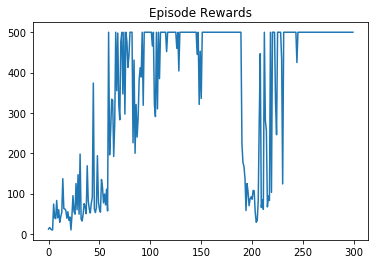

In [5]:
episode_num = 300
all_episode_r = np.zeros(episode_num)
max_episode_r = 0
best_100_avg = 0

for i in range(episode_num):
    # Reduce epsilon over time.
    eps = 1.0/np.sqrt(i+1)
    
    # Play episode.
    all_episode_r[i] = PlayEpisode(environment, rl_agent, eps)
    
    if i % 20 == 0:
        print("Episode", i, "Average Reward", all_episode_r[max(0, i-19):i+1].mean())


plt.plot(all_episode_r)
plt.title("Episode Rewards")
plt.show()

In [6]:
s_t0 = environment.reset()
s_t0 = np.reshape(s_t0, [1, 4])
print(s_t0)
#print(np.concatenate((s_t0, s_t0), axis=0))

[[ -1.63482219e-02  -4.36939999e-02  -8.13127816e-05  -3.60705728e-02]]


In [7]:
asdf = np.empty([0,4])
print(np.concatenate((asdf, s_t0), axis=0))
s2 = environment.reset()
s2 = np.reshape(s_t0, [1,4])
print(np.concatenate((s_t0, s2), axis=0))

[[ -1.63482219e-02  -4.36939999e-02  -8.13127816e-05  -3.60705728e-02]]
[[ -1.63482219e-02  -4.36939999e-02  -8.13127816e-05  -3.60705728e-02]
 [ -1.63482219e-02  -4.36939999e-02  -8.13127816e-05  -3.60705728e-02]]


In [8]:
from gym.wrappers import Monitor

In [9]:
asdfa = 
def VideoWrite(i):
    return True


episode_num = 10
all_episode_r = np.zeros(episode_num)
#environment = Monitor(environment, directory='tmp/videos',video_callable=VideoWrite, write_upon_reset=True, force=True)
    

for i in range(episode_num):
    all_episode_r[i] = PlayEpisode(environment, rl_agent, 0)
        
# Required inorder to save final video.
environment.reset()

print(all_episode_r.mean())
plt.plot(all_episode_r)
plt.title("Best Q 10 Episode Rewards")
plt.show()

SyntaxError: invalid syntax (<ipython-input-9-bceb17af30d8>, line 1)